# This is Causal Flow for Observability (as of ACM 2.11) 

Created using domain knowledge of Observability team.

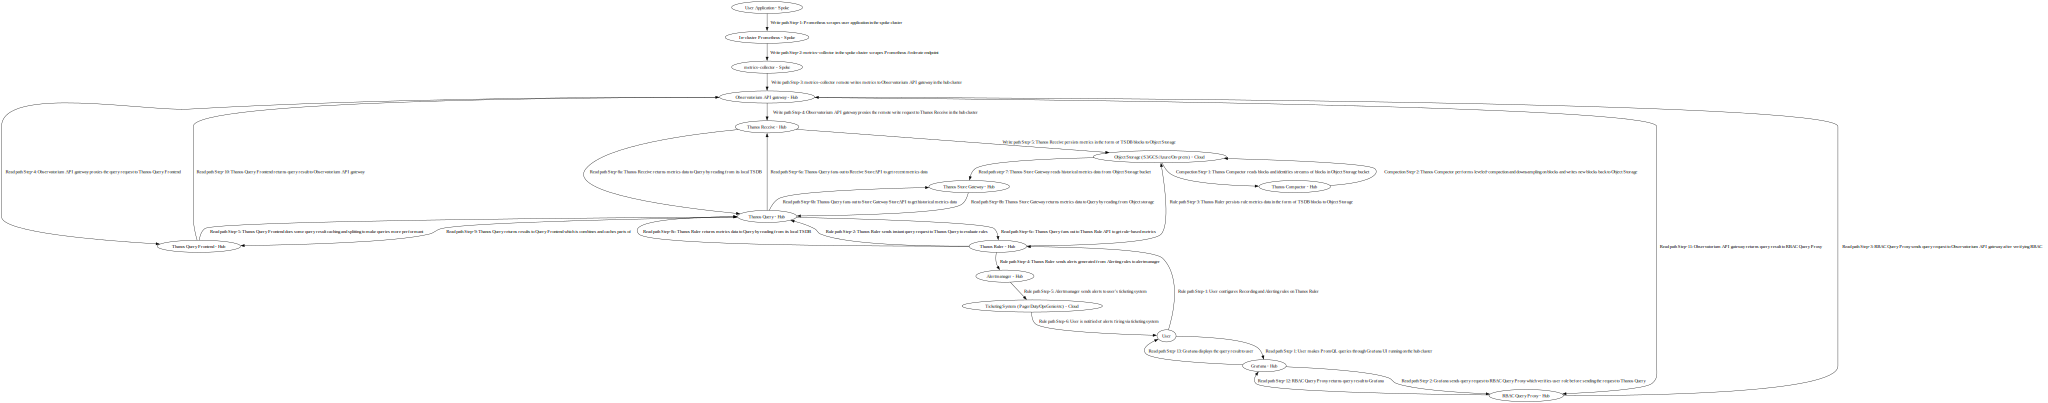

In [39]:
import graphviz
import io

acmo11ycomplete=graphviz.Digraph()

acmo11ycomplete.edge('User Application - Spoke','In-cluster Prometheus - Spoke', label="Write path Step-1: Prometheus scrapes user application in the spoke cluster")
acmo11ycomplete.edge('In-cluster Prometheus - Spoke','metrics-collector - Spoke', label="Write path Step-2: metrics-collector in the spoke cluster scrapes Prometheus /federate endpoint")
acmo11ycomplete.edge('metrics-collector - Spoke','Observatorium API gateway - Hub', label="Write path Step-3: metrics-collector remote writes metrics to Observatorium API gateway in the hub cluster")
acmo11ycomplete.edge('Observatorium API gateway - Hub','Thanos Receive - Hub', label="Write path Step-4: Observatorium API gateway proxies the remote write request to Thanos Receive in the hub cluster")
acmo11ycomplete.edge('Thanos Receive - Hub','Object Storage (S3/GCS/Azure/On-prem) - Cloud', label="Write path Step-5: Thanos Receive persists metrics in the form of TSDB blocks to Object Storage")

acmo11ycomplete.edge('User','Grafana - Hub', label="Read path Step-1: User makes PromQL queries through Grafana UI running on the hub cluster")
acmo11ycomplete.edge('Grafana - Hub','RBAC Query Proxy - Hub', label="Read path Step-2: Grafana sends query request to RBAC Query Proxy which verifies user role before sending the request to Thanos Query")
acmo11ycomplete.edge('RBAC Query Proxy - Hub','Observatorium API gateway - Hub', label="Read path Step-3: RBAC Query Proxy sends query request to Observatorium API gateway after verifying RBAC")
acmo11ycomplete.edge('Observatorium API gateway - Hub','Thanos Query Frontend - Hub', label="Read path Step-4: Observatorium API gateway proxies the query request to Thanos Query Frontend")
acmo11ycomplete.edge('Thanos Query Frontend - Hub','Thanos Query - Hub', label="Read path Step-5: Thanos Query Frontend does some query result caching and splitting to make queries more performant")
acmo11ycomplete.edge('Thanos Query - Hub','Thanos Receive - Hub', label="Read path Step-6a: Thanos Query fans out to Receive StoreAPI to get recent metrics data")
acmo11ycomplete.edge('Thanos Query - Hub','Thanos Store Gateway - Hub', label="Read path Step-6b: Thanos Query fans out to Store Gateway StoreAPI to get historical metrics data")
acmo11ycomplete.edge('Object Storage (S3/GCS/Azure/On-prem) - Cloud', 'Thanos Store Gateway - Hub', label="Read path step-7: Thanos Store Gateway reads historical metrics data from Object Storage bucket")
acmo11ycomplete.edge('Thanos Query - Hub','Thanos Ruler - Hub', label="Read path Step-6c: Thanos Query fans out to Thanos Rule API to get rule-based metrics")
acmo11ycomplete.edge('Thanos Receive - Hub','Thanos Query - Hub', label="Read path Step-8a: Thanos Receive returns metrics data to Query by reading from its local TSDB")
acmo11ycomplete.edge('Thanos Store Gateway - Hub','Thanos Query - Hub', label="Read path Step-8b: Thanos Store Gateway returns metrics data to Query by reading from Object storage")
acmo11ycomplete.edge('Thanos Ruler - Hub','Thanos Query - Hub', label="Read path Step-8c: Thanos Ruler returns metrics data to Query by reading from its local TSDB")
acmo11ycomplete.edge('Thanos Query - Hub', 'Thanos Query Frontend - Hub', label="Read path Step-9: Thanos Query returns results to Query Frontend which is combines and caches parts of")
acmo11ycomplete.edge('Thanos Query Frontend - Hub','Observatorium API gateway - Hub', label="Read path Step-10: Thanos Query Frontend returns query result to Observatorium API gateway")
acmo11ycomplete.edge('Observatorium API gateway - Hub','RBAC Query Proxy - Hub', label="Read path Step-11: Observatorium API gateway returns query result to RBAC Query Proxy")
acmo11ycomplete.edge('RBAC Query Proxy - Hub','Grafana - Hub', label="Read path Step-12: RBAC Query Proxy returns query result to Grafana")
acmo11ycomplete.edge('Grafana - Hub','User', label="Read path Step-13: Grafana displays the query result to user")

acmo11ycomplete.edge('User','Thanos Ruler - Hub', label="Rule path Step-1: User configures Recording and Alerting rules on Thanos Ruler")
acmo11ycomplete.edge('Thanos Ruler - Hub','Thanos Query - Hub', label="Rule path Step-2: Thanos Ruler sends instant query request to Thanos Query to evaluate rules")
acmo11ycomplete.edge('Thanos Ruler - Hub','Object Storage (S3/GCS/Azure/On-prem) - Cloud', label="Rule path Step-3: Thanos Ruler persists rule metrics data in the form of TSDB blocks to Object Storage")
acmo11ycomplete.edge('Thanos Ruler - Hub','Alertmanager - Hub', label="Rule path Step-4: Thanos Ruler sends alerts generated from Alerting rules to alertmanager")
acmo11ycomplete.edge('Alertmanager - Hub','Ticketing System (PagerDuty/OpsGenie/etc) - Cloud', label="Rule path Step-5: Alertmanager sends alerts to user's ticketing system")
acmo11ycomplete.edge('Ticketing System (PagerDuty/OpsGenie/etc) - Cloud','User', label="Rule path Step-6: User is notified of alerts firing via ticketing system")

acmo11ycomplete.edge('Object Storage (S3/GCS/Azure/On-prem) - Cloud','Thanos Compactor - Hub', label="Compaction Step-1: Thanos Compactor reads blocks and identifies streams of blocks in Object Storage bucket")
acmo11ycomplete.edge('Thanos Compactor - Hub','Object Storage (S3/GCS/Azure/On-prem) - Cloud', label="Compaction Step-2: Thanos Compactor performs leveled-compaction and downsampling on blocks and writes new blocks back to Object Storage")

acmo11ycomplete

# Enter LLM

An Observability Engineer would use the information above to arrive at an amazingly complex answer. 
Below blocks show how well it performs.

In [40]:
O11Y_PROMPT="""You underdstand Red Hat Advanced cluster management, Observability (O11y) Pillar well and have a good understanding of upstream Thanos and Prometheus ecosystem. \
You are well versed in the concepts of PromQL, Prometheus metrics data model, remote write and TSDBs. \
We are giving you details about the Thanos setup and topology, \
such as the relationships between nodes, paths, connectivity, and other related queries \
You will be provided the topology as a Graphviz digraph in plaintext: {composition}. \
Answer the question based on the above topology and your knowledge about ACM Observability. \
A few other things to keep in mind: \
There are 3 types of nodes here: Spoke, Hub and Cloud.\
The nodes that have names ending in Cloud are resources managed by User in some particular cloud environment of their choosing. \
The nodes that have names ending in Spoke are ACM Observability workloads on the ACM managed or spoke clusters. \
The nodes that have names ending in Hub are ACM Observability workloads on the ACM management or hub cluster. \
There is a User node which represents the real user taking an action. \
In the answer do not refer to the topology diagram. The user may not have access to it."""

# Encoding digraph as plaintext

In [41]:
# There is a way to pass this as json as well
data = io.StringIO()

data.write(acmo11ycomplete.pipe(format="plain").decode('utf-8'))
data.seek(0)

composition = data.read()

In [42]:
msgs = ["What components run on the hub cluster and what components run on spoke cluster.",\
        "When a user application is scraped by Prometheus, what happens to the scraped data and where does it end up?",\
        "How does a user's PromQL query get answered?",\
        "A user is not able to see their historical metrics, what can be the cause of that?",\
        "A user notices their metrics-collector pod is failing to write metrics, why?",\
        "How does a user get alerted after they set a alerting rule on Thanos Ruler?",\
        "A user notices a lot of slow queries, especially when they query for historical metrics. They also have alerts firing on Thanos Compactor? What could be the cause?"
      ]

In [43]:
import os
import openai
from dotenv import load_dotenv, find_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

_ = load_dotenv(find_dotenv()) 
openai.api_key  = os.getenv('OPENAI_API_KEY')

for msg in msgs:
    messages = [
            SystemMessage(content=O11Y_PROMPT.format(composition=composition)), 
            HumanMessage(content=msg)        
       ]

    model = ChatOpenAI(model="gpt-4", temperature=0)
    response = model.invoke(messages)
    print("")
    print("--------------")
    print(msg)
    print("--------------")
    print(response.content)


--------------
What components run on the hub cluster and what components run on spoke cluster.
--------------
On the hub cluster, the following components are running:

1. Observatorium API gateway: This component proxies the remote write request to Thanos Receive and also proxies the query request to Thanos Query Frontend.

2. Thanos Receive: This component receives metrics from the Observatorium API gateway and persists them in the form of TSDB blocks to Object Storage.

3. Thanos Query: This component fans out to Receive StoreAPI to get recent metrics data, to Store Gateway StoreAPI to get historical metrics data, and to Thanos Rule API to get rule-based metrics.

4. Thanos Store Gateway: This component reads historical metrics data from Object Storage bucket.

5. Thanos Ruler: This component evaluates Recording and Alerting rules configured by the user and sends alerts generated from Alerting rules to Alertmanager.

6. Alertmanager: This component sends alerts to the user's ticke